# In search for persistent customer support problems

Author:
* Luis

We want to search for persistent issues in a store customer support. 
We define "persistent issue" when a issue level/count for a certain store is higher by x*std(Moving Average of similar sized stores number of occurencies of a issue), being x a positive integer number (to be determined), for t periods of time.

We start by investigating if stores have different volumes os reviews, what would indicate that some stores are bigger than others (one hypothesis is that larger stores have more clients and therefore a larger number of reviews) and we must account for that when estimating the MA.

Next, we will compare stores issues levels with the relevant moving average for that issue. We hope to identify stores that deviates a lot and use that to inform stakeholders to investigate further.


In [1]:
%cd ..

/home/luis/ds4a/notebooks


In [2]:
from src.loading import load_dataset
from pprint import pprint

# dataset_path = "dataset/GB_tagged_final_0501"
dataset_path = "final_dataset_GB_1704"
reviewsGB = load_dataset(dataset_path, "id_review", "jl")

print(f"We have a total of {len(reviewsGB)} reviews!")
pprint(reviewsGB[0])

We have a total of 140416 reviews!
{'caption': '',
 'geo_location': {'lat': '-23.5975251', 'long': '-46.6025457'},
 'id_review': 'ChZDSUhNMG9nS0VJQ0FnSUNjemR6YkRREAEaFkNKMExMS0tRQnA3NmhQUzlCWkoyTkE',
 'n_photo_user': 0,
 'n_review_user': 1,
 'rating': 4.0,
 'relative_date': '3 semanas atrás',
 'retrieval_date': '2020-04-15T05:32:36Z',
 'store': 'magazine-luiza',
 'url_user': 'https://www.google.com/maps/contrib/114096832037584768938?hl=pt-BR',
 'username': 'Tiago Leonel Barreto'}


In [70]:
import pandas as pd
from src.cleaning import format_GB_to_df

dff = pd.DataFrame([format_GB_to_df(row) for row in reviewsGB])
dff = dff[[col for col in dff.columns if col not in ["products_Home Appliances","products_Eletronics","products_Furniture","products_Accessories","products_Decoration","products_Others"]]]  # remove product columns that are not tagged
dff = dff.loc[(dff.store != "") &  (dff.store.notna())]
dff.head()

,caption,id_review,n_photo_user,n_review_user,rating,relative_date,retrieval_date,store,url_user,username,...,product_issues_Electrical problems,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues
0,,ChZDSUhNMG9nS0VJQ0FnSUNjemR6YkRREAEaFkNKMExMS0...,0,1,4.0,3 semanas atrás,2020-04-15T05:32:36Z,magazine-luiza,https://www.google.com/maps/contrib/1140968320...,Tiago Leonel Barreto,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Adorei o lugar, foi rápido de ser atendido.",ChZDSUhNMG9nS0VJQ0FnSUNjMWZTcElREAEaFmJPMVBBYk...,0,0,5.0,3 semanas atrás,2020-04-15T05:32:36Z,magazine-luiza,https://www.google.com/maps/contrib/1151737163...,Lucas Viana,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,,ChZDSUhNMG9nS0VJQ0FnSUNjbGJtbVNnEAEaFksxYk1IaD...,0,0,5.0,4 semanas atrás,2020-04-15T05:32:36Z,magazine-luiza,https://www.google.com/maps/contrib/1064427349...,Véio Veiako,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gostei,ChdDSUhNMG9nS0VJQ0FnSUNjMmVDTzFnRRABGhYyRVc5bF...,0,0,4.0,4 semanas atrás,2020-04-15T05:32:36Z,magazine-luiza,https://www.google.com/maps/contrib/1158267094...,Eduardo Martins da Costa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,ChdDSUhNMG9nS0VJQ0FnSUNja2NDMWt3RRABGhZ1a0QzYV...,0,0,4.0,um mês atrás,2020-04-15T05:32:36Z,magazine-luiza,https://www.google.com/maps/contrib/1049002017...,Lucas Ferreira,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Load tagged dataset from GB
dataset_path = "dataset/gb_tagged/"
reviewsGB_tagged = load_dataset(dataset_path, "id_review", "jsonl")

In [48]:
dff_tagged = pd.DataFrame([format_GB_to_df(row) for row in reviewsGB_tagged])
dff_tagged = dff_tagged[[col for col in dff_tagged.columns if col not in ["products_Home Appliances","products_Eletronics","products_Furniture","products_Accessories","products_Decoration","products_Others"]]]  # remove product columns that are not tagged
dff_tagged.head()

,caption,id_review,n_photo_user,n_review_user,rating,relative_date,retrieval_date,store,url_user,username,...,product_issues_Electrical problems,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues
0,Vende eletros domésticos quebrado. Comprei um...,ChZDSUhNMG9nS0VJQ0FnSURNNXBERUFREAEaFjZwVEFadG...,0,39,2.0,3 meses atrás,2020-04-15T05:33:14Z,magazine-luiza,https://www.google.com/maps/contrib/1078399353...,Mercia Oliveira,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
1,Som muito alto,ChdDSUhNMG9nS0VJQ0FnSUNNdjhMWHF3RRABGhZ2bHdkUX...,0,0,1.0,4 meses atrás,2020-04-15T05:33:21Z,magazine-luiza,https://www.google.com/maps/contrib/1096235498...,Wendy Castiello,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
2,Péssimo atendimento e não tem telefone para at...,ChZDSUhNMG9nS0VJQ0FnSUNNdDVidE5nEAEaFmE3R1pMTG...,0,14,1.0,4 meses atrás,2020-04-15T05:33:21Z,magazine-luiza,https://www.google.com/maps/contrib/1136403911...,Gilberto Alves,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
3,Péssima.. Pessoas descompromissadas...me impe...,ChdDSUhNMG9nS0VJQ0FnSUQwdE5QTzVRRRABGhZVOThjbX...,0,1,1.0,5 meses atrás,2020-04-15T05:33:41Z,magazine-luiza,https://www.google.com/maps/contrib/1074240831...,Anderson Freire Carniel,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
4,Bom atendimento.,ChdDSUhNMG9nS0VJQ0FnSUQwa083dHdnRRABGhYwY000cj...,0,0,1.0,5 meses atrás,2020-04-15T05:33:41Z,magazine-luiza,https://www.google.com/maps/contrib/1176573277...,Helena Stauber,...,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,3.0


In [86]:
# Merge both datasets
df_final = pd.concat([dff.loc[~(dff.id_review.isin(dff_tagged.id_review))], dff_tagged], axis=0)
df_final.describe()

,n_photo_user,n_review_user,rating,len_comment,relative,others,product_issues_Quality,product_issues_Damaged,product_issues_Electrical problems,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues
count,140396.0,140396.000000,140396.000000,140396.000000,140396.000000,0.0,3246.0,3243.0,0.0,0.0,2201.0,2944.0,5418.0,2942.0,8.0,0.0,3246.000000,6897.000000
mean,0.0,3.874619,3.918965,22.255356,306.346199,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.999076,1.959258
std,0.0,20.995457,1.273461,69.500694,238.970597,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.030392,0.765364
min,0.0,0.000000,1.000000,0.000000,21.000000,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.000000,1.000000
25%,0.0,0.000000,3.000000,0.000000,120.000000,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,2.000000,1.000000
50%,0.0,0.000000,4.000000,0.000000,270.000000,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,2.000000,2.000000
75%,0.0,2.000000,5.000000,18.000000,365.000000,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,2.000000,3.000000
max,0.0,1253.000000,5.000000,4096.000000,2920.000000,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,2.000000,4.000000


In [87]:
def get_stores_ids(gb_df):
    """
    Get a human readable id for each store
    """
    store_map = dict()
    for store in gb_df.store.unique():
        unique_stores = gb_df.loc[gb_df.store == store].apply(lambda x: f"{x['latitude']}_{x['longitude']}", axis=1).unique()
        store_map.update({geo:f"{store}_{idx}" for idx,geo in enumerate(unique_stores)})
    
    return gb_df.apply(lambda x: store_map[f"{x['latitude']}_{x['longitude']}"], axis=1)

df_final["store_id"] = get_stores_ids(df_final)
df_final.store_id.head()

0    magazine-luiza_0
1    magazine-luiza_0
2    magazine-luiza_0
3    magazine-luiza_0
4    magazine-luiza_0
Name: store_id, dtype: object

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# f, axes = plt.subplots(1, figsize=(7, 7), sharex=True)
sns.distplot(dff.groupby("store_id").count().id_review, kde=False, color="b", axlabel="# of reviews")

## Store size variable
We need to compare apples with apples, thus we will create class variables for each of the previous histogram buckets (given that they are somewhat equaly distributed).

Next, we proceed to check what is the percentage of negative reviews for each bucket.

In [37]:
dff.head()

,caption,id_review,n_photo_user,n_review_user,rating,relative_date,retrieval_date,store,url_user,username,...,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues,year,month,week,store_id
0,,ChZDSUhNMG9nS0VJQ0FnSUNjemR6YkRREAEaFkNKMExMS0...,0,1,4.0,3 semanas atrás,2020-04-15T05:32:36Z,magazine-luiza,https://www.google.com/maps/contrib/1140968320...,Tiago Leonel Barreto,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,03/2020,13,magazine-luiza_0
1,"Adorei o lugar, foi rápido de ser atendido.",ChZDSUhNMG9nS0VJQ0FnSUNjMWZTcElREAEaFmJPMVBBYk...,0,0,5.0,3 semanas atrás,2020-04-15T05:32:36Z,magazine-luiza,https://www.google.com/maps/contrib/1151737163...,Lucas Viana,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,03/2020,13,magazine-luiza_0
2,,ChZDSUhNMG9nS0VJQ0FnSUNjbGJtbVNnEAEaFksxYk1IaD...,0,0,5.0,4 semanas atrás,2020-04-15T05:32:36Z,magazine-luiza,https://www.google.com/maps/contrib/1064427349...,Véio Veiako,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,03/2020,12,magazine-luiza_0
3,Gostei,ChdDSUhNMG9nS0VJQ0FnSUNjMmVDTzFnRRABGhYyRVc5bF...,0,0,4.0,4 semanas atrás,2020-04-15T05:32:36Z,magazine-luiza,https://www.google.com/maps/contrib/1158267094...,Eduardo Martins da Costa,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,03/2020,12,magazine-luiza_0
4,,ChdDSUhNMG9nS0VJQ0FnSUNja2NDMWt3RRABGhZ1a0QzYV...,0,0,4.0,um mês atrás,2020-04-15T05:32:36Z,magazine-luiza,https://www.google.com/maps/contrib/1049002017...,Lucas Ferreira,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,03/2020,12,magazine-luiza_0


In [88]:
vars_of_interest = ['id_review', 'rating',       'store', 'latitude', 'longitude', 'date_comment', 'product_issues_Quality', 'product_issues_Damaged',
       'product_issues_Electrical problems', 'product_issues_Missing pieces',
       'business_issues_Payment', 'business_issues_Maintenance',
       'business_issues_Customer Services', 'business_issues_Delivery',
       'business_issues_Online Services', 'products', 'product_issues',
       'business_issues', 'store_id']
dfi = df_final[vars_of_interest]
dfi = dfi.rename(columns={"store": "company"})
dfi.head()

,id_review,rating,company,latitude,longitude,date_comment,product_issues_Quality,product_issues_Damaged,product_issues_Electrical problems,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues,store_id
0,ChZDSUhNMG9nS0VJQ0FnSUNjemR6YkRREAEaFkNKMExMS0...,4.0,magazine-luiza,-23.5975251,-46.6025457,2020-03-25 05:32:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magazine-luiza_0
1,ChZDSUhNMG9nS0VJQ0FnSUNjMWZTcElREAEaFmJPMVBBYk...,5.0,magazine-luiza,-23.5975251,-46.6025457,2020-03-25 05:32:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magazine-luiza_0
2,ChZDSUhNMG9nS0VJQ0FnSUNjbGJtbVNnEAEaFksxYk1IaD...,5.0,magazine-luiza,-23.5975251,-46.6025457,2020-03-18 05:32:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magazine-luiza_0
3,ChdDSUhNMG9nS0VJQ0FnSUNjMmVDTzFnRRABGhYyRVc5bF...,4.0,magazine-luiza,-23.5975251,-46.6025457,2020-03-18 05:32:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magazine-luiza_0
4,ChdDSUhNMG9nS0VJQ0FnSUNja2NDMWt3RRABGhZ1a0QzYV...,4.0,magazine-luiza,-23.5975251,-46.6025457,2020-03-16 05:32:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magazine-luiza_0


In [98]:
import pickle

pickle.dump(dfi, open("views/stores_comments.pckl", "wb" ) )
pickle.dump(dfi.groupby(["store_id", "latitude","longitude"]).mean().rating.reset_index(), open("views/store_avg_rating.pckl", "wb" ))

In [100]:
test = dfi.groupby(["store_id", "latitude","longitude"]).mean().rating.reset_index()
test

,store_id,latitude,longitude,rating
0,casas-bahia_0,-23.6664932,-46.6582811,3.755435
1,casas-bahia_1,-23.483583,-46.6468911,3.859431
2,casas-bahia_10,-23.4947944,-46.4409685,3.938856
3,casas-bahia_11,-23.672686,-46.775737,3.721739
4,casas-bahia_12,-23.5391156,-46.5781471,3.883876
...,...,...,...,...
238,sylvia-design_1,-23.5997497,-46.6880305,4.018519
239,sylvia-design_2,-23.5349549,-46.6024344,3.461538
240,sylvia-design_3,-23.5119906,-46.6268904,3.804504
241,sylvia-design_4,-23.5391825,-46.5776248,3.847411


# Relative position store metrics

We need to compare apples with apples, so we are categorizing our stores using their number of reviews as a proxy to their size.

In [109]:
def map_size_class(value):
    if value > 1200:
        return "t6"
    elif value > 1000:
        return "t5"
    elif value > 800:
        return "t4"
    elif value > 600:
        return "t3"
    elif value > 400:
        return "t2"
    elif value > 200:
        return "t1"
    else:
        return "t0"

store_class_map = df_final.groupby("store_id").count().id_review.apply(lambda x: map_size_class(x))
store_class_map = store_class_map.to_dict()

In [111]:
# Add store type to main df
df_final["store_type"] = df_final["store_id"].apply(lambda x: store_class_map[x])
df_final.head()

,caption,id_review,n_photo_user,n_review_user,rating,relative_date,retrieval_date,store,url_user,username,...,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues,store_id,store_type
0,,ChZDSUhNMG9nS0VJQ0FnSUNjemR6YkRREAEaFkNKMExMS0...,0,1,4.0,3 semanas atrás,2020-04-15T05:32:36Z,magazine-luiza,https://www.google.com/maps/contrib/1140968320...,Tiago Leonel Barreto,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magazine-luiza_0,t3
1,"Adorei o lugar, foi rápido de ser atendido.",ChZDSUhNMG9nS0VJQ0FnSUNjMWZTcElREAEaFmJPMVBBYk...,0,0,5.0,3 semanas atrás,2020-04-15T05:32:36Z,magazine-luiza,https://www.google.com/maps/contrib/1151737163...,Lucas Viana,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magazine-luiza_0,t3
2,,ChZDSUhNMG9nS0VJQ0FnSUNjbGJtbVNnEAEaFksxYk1IaD...,0,0,5.0,4 semanas atrás,2020-04-15T05:32:36Z,magazine-luiza,https://www.google.com/maps/contrib/1064427349...,Véio Veiako,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magazine-luiza_0,t3
3,Gostei,ChdDSUhNMG9nS0VJQ0FnSUNjMmVDTzFnRRABGhYyRVc5bF...,0,0,4.0,4 semanas atrás,2020-04-15T05:32:36Z,magazine-luiza,https://www.google.com/maps/contrib/1158267094...,Eduardo Martins da Costa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magazine-luiza_0,t3
4,,ChdDSUhNMG9nS0VJQ0FnSUNja2NDMWt3RRABGhZ1a0QzYV...,0,0,4.0,um mês atrás,2020-04-15T05:32:36Z,magazine-luiza,https://www.google.com/maps/contrib/1049002017...,Lucas Ferreira,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magazine-luiza_0,t3


## Checking data distribution over time
Well, we see that we do not have enough data to go monthly. At least not in store level and before 2019-04.

In [212]:
test1 = df_final.fillna(0).groupby(["store_type","date_comment"]).mean().loc['t1',:].resample('M').count()
test1.tail(20)

,n_photo_user,n_review_user,rating,len_comment,relative,others,product_issues_Quality,product_issues_Damaged,product_issues_Electrical problems,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues
date_comment,,,,,,,,,,,,,,,,,,
2018-08-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-09-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-10-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-11-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-12-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-02-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-03-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-04-30,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253


In [208]:
test1 = df_final.fillna(0).groupby(["store_type","date_comment"]).mean().loc['t1',:].resample('Q').count()
test1

,n_photo_user,n_review_user,rating,len_comment,relative,others,product_issues_Quality,product_issues_Damaged,product_issues_Electrical problems,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues
date_comment,,,,,,,,,,,,,,,,,,
2014-06-30,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2014-09-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-12-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-03-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-06-30,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2015-09-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-12-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-03-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06-30,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15


In [218]:
enough_points = df_final.fillna(0).groupby(["store_type","date_comment"]).mean().loc['t1',:].resample('Q').count() >= 20

means = df_final.fillna(0).groupby(["store_type","date_comment"]).mean().loc['t1',:].resample('Q').mean()

good_means = means[enough_points]
good_means

,n_photo_user,n_review_user,rating,len_comment,relative,others,product_issues_Quality,product_issues_Damaged,product_issues_Electrical problems,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues
date_comment,,,,,,,,,,,,,,,,,,
2014-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Getting benchmarks and store metrics
We are getting quartely ts starting from "2019-06-30" -> thats when we have more data to actually aggregate meaningfuly

In [209]:
def get_benchmarks(df,freq="M", since_dt="2018-01-01"):
    """
    Estimate time series metrics by resample for given time frequency
    """
    types_dfs =[]
    for store_type in df.store_type.unique():
        tmp_df = df_final.fillna(0).groupby(["store_type","date_comment"]).mean().loc[store_type,:].resample(freq).mean()
        tmp_df = tmp_df.mask(tmp_df == 0).interpolate().reset_index()
        tmp_df["store_type"] = store_type
        types_dfs.append(tmp_df)
    dff = pd.concat(types_dfs, axis=0)
    return dff.loc[dff.date_comment >= since_dt]
        
benchmarks = get_benchmarks(df_final, freq="Q", since_dt="2019-06-30")

In [210]:
benchmarks.head()

,date_comment,n_photo_user,n_review_user,rating,len_comment,relative,others,product_issues_Quality,product_issues_Damaged,product_issues_Electrical problems,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues,store_type
20,2019-06-30,NaN,3.962569,3.900497,22.431685,353.088972,NaN,0.021305,0.021305,NaN,NaN,0.015883,0.019596,0.034730,0.019640,0.000125,NaN,0.042609,0.089974,t3
21,2019-09-30,NaN,3.953088,3.992835,15.539572,239.145570,NaN,0.022387,0.022387,NaN,NaN,0.013099,0.018169,0.029928,0.021645,0.000125,NaN,0.044773,0.082840,t3
22,2019-12-31,NaN,3.794503,3.943704,19.889342,147.201166,NaN,0.022800,0.022800,NaN,NaN,0.021993,0.018054,0.039347,0.015204,0.000125,NaN,0.045599,0.094598,t3
23,2020-03-31,NaN,4.274146,4.028412,24.909067,56.697133,NaN,0.023177,0.023177,NaN,NaN,0.014039,0.020282,0.038498,0.017898,0.000125,NaN,0.046353,0.090717,t3
24,2019-06-30,NaN,3.888736,3.883963,20.818592,353.046039,NaN,0.021060,0.021060,NaN,NaN,0.015424,0.022365,0.038734,0.021542,NaN,NaN,0.042120,0.098064,t5


In [231]:
def get_stores_metrics(df, freq="M", since_dt="2018-01-01", minimum_count=20):
    """
    Estimate time series metrics by resample for given frequency and minimum count for aggregation
    """
    types_dfs =[]
    for store_id in df.store_id.unique():
        
        # Get boolean mask of minimum count
        enough_points = df_final.fillna(0).groupby(["store_id","date_comment"]).mean().loc[store_id,:].resample(freq).count() >= minimum_count
        
        # Compute agg means
        tmp_df = df_final.fillna(0).groupby(["store_id","date_comment"]).mean().loc[store_id,:].resample(freq).mean()
        
        # Mask out
        tmp_df = tmp_df[enough_points]
        
        # Interpolate when possible
        tmp_df = tmp_df.mask(tmp_df == 0).interpolate().reset_index()
        
        tmp_df["store_id"] = store_id
        types_dfs.append(tmp_df)
    dff = pd.concat(types_dfs, axis=0)
    
    return dff.loc[dff.date_comment >= since_dt]

store_ts = get_stores_metrics(df_final, freq="Q", since_dt="2019-06-30", minimum_count=5)
store_ts["store_type"] = store_ts.store_id.apply(lambda x: store_class_map[x])
store_ts.head()

,date_comment,n_photo_user,n_review_user,rating,len_comment,relative,others,product_issues_Quality,product_issues_Damaged,product_issues_Electrical problems,...,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues,store_id,store_type
12,2019-06-30,NaN,4.193910,3.973077,22.797451,350.961538,NaN,0.023077,0.023077,NaN,...,0.026007,0.007692,0.037546,0.011538,NaN,NaN,0.046154,0.082784,magazine-luiza_0,t3
13,2019-09-30,NaN,4.042857,3.985000,13.267500,234.000000,NaN,0.036786,0.036786,NaN,...,0.026007,0.064286,0.064286,0.039286,NaN,NaN,0.073571,0.167857,magazine-luiza_0,t3
14,2019-12-31,NaN,3.880952,3.705952,18.819048,154.285714,NaN,0.017857,0.017857,NaN,...,0.026007,0.014286,0.028571,0.046429,NaN,NaN,0.035714,0.089286,magazine-luiza_0,t3
15,2020-03-31,NaN,2.439435,4.212913,13.693271,56.583333,NaN,0.008333,0.008333,NaN,...,0.026007,0.014286,0.028571,0.046429,NaN,NaN,0.016667,0.089286,magazine-luiza_0,t3
16,2019-06-30,NaN,3.792196,3.886602,23.954422,347.619048,NaN,0.014815,0.014815,NaN,...,0.034921,0.009524,0.044444,0.004762,NaN,NaN,0.029630,0.093651,magazine-luiza_1,t3


In [232]:
import pickle
# Save views
pickle.dump(store_ts, open("views/stores_ts_quarterly.pckl", "wb" ) )
pickle.dump(benchmarks, open("views/benchmarks_ts_quarterly.pckl", "wb" ))

In [237]:
def format_issues_columns(col):
    return "_".join(col.split(" ")).lower()

def estimate_rankings(df, date, store_type):
    """
    Estimate relative rankings for each variable of interest given a date and store type
    """
    ranking_variables = ["rating",'product_issues_Quality', 'product_issues_Damaged', 'product_issues_Electrical problems', 'product_issues_Missing pieces',
                         'business_issues_Payment', 'business_issues_Maintenance', 'business_issues_Customer Services', 'business_issues_Delivery',
                         'business_issues_Online Services', 'product_issues', 'business_issues']
    rankings = []
    for rank_var in ranking_variables:
        if rank_var == "rating":
            tmp_rank = df.loc[(df.date_comment == date) & (df.store_type == store_type)][rank_var].rank(ascending=True, pct=True)
        else:
            tmp_rank = df.loc[(df.date_comment == date) & (df.store_type == store_type)][rank_var].rank(ascending=False, pct=True)
        tmp_rank.name = f"{format_issues_columns(rank_var)}_rank"
        rankings.append(tmp_rank)
    return pd.concat(rankings, axis=1)

def build_ranks(df):
    """
    Estimate all rankings for a gb store time series 
    """
    ranked_df = []
    for stor_type in df.store_type.unique():
        for dt in df.date_comment.unique():
            ranked_df.append(pd.concat([estimate_rankings(df, dt, stor_type), df.loc[(df.date_comment == dt) & (df.store_type == stor_type)]], axis=1))
    return pd.concat(ranked_df, axis=0)

stores_ranked_ts = build_ranks(store_ts)


In [240]:
pickle.dump(stores_ranked_ts, open("views/ranked_stores_ts_quarterly.pckl", "wb" ) )
stores_ranked_ts


,rating_rank,product_issues_quality_rank,product_issues_damaged_rank,product_issues_electrical_problems_rank,product_issues_missing_pieces_rank,business_issues_payment_rank,business_issues_maintenance_rank,business_issues_customer_services_rank,business_issues_delivery_rank,business_issues_online_services_rank,...,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues,store_id,store_type
12,0.642857,0.357143,0.357143,NaN,NaN,0.142857,1.000000,0.500000,0.678571,NaN,...,0.026007,0.007692,0.037546,0.011538,NaN,NaN,0.046154,0.082784,magazine-luiza_0,t3
16,0.464286,0.750000,0.750000,NaN,NaN,0.071429,0.964286,0.232143,0.964286,NaN,...,0.034921,0.009524,0.044444,0.004762,NaN,NaN,0.029630,0.093651,magazine-luiza_1,t3
12,0.678571,0.214286,0.214286,NaN,NaN,0.107143,0.285714,0.392857,0.321429,NaN,...,0.027083,0.022917,0.039583,0.020833,NaN,NaN,0.055556,0.110417,sylvia-design_0,t3
12,0.857143,0.964286,0.964286,NaN,NaN,0.821429,0.785714,1.000000,0.607143,NaN,...,0.010741,0.013704,0.017778,0.013704,NaN,NaN,0.020000,0.055926,magazine-luiza_4,t3
16,0.178571,0.250000,0.250000,NaN,NaN,0.589286,0.392857,0.571429,0.892857,1.0,...,0.013043,0.021739,0.035266,0.009179,0.004348,NaN,0.052174,0.083575,casas-bahia_6,t3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,0.250000,0.550000,0.550000,NaN,NaN,0.500000,0.350000,0.375000,0.300000,NaN,...,0.019231,0.023077,0.042308,0.023077,NaN,NaN,0.046154,0.107692,casas-bahia_77,t2
19,0.400000,0.450000,0.450000,NaN,NaN,0.850000,0.150000,0.375000,0.975000,NaN,...,0.009615,0.032692,0.042308,0.007692,NaN,NaN,0.065385,0.092308,magazine-luiza_57,t2
11,0.200000,0.200000,0.200000,NaN,NaN,0.800000,0.200000,0.450000,0.400000,NaN,...,0.010000,0.030000,0.040000,0.020000,NaN,NaN,0.106667,0.100000,casas-bahia_79,t2
15,0.650000,0.150000,0.150000,NaN,NaN,0.100000,0.600000,0.900000,0.625000,NaN,...,0.050000,0.014468,0.014468,0.017593,NaN,NaN,0.122222,0.046528,casas-bahia_80,t2


{'magazine-luiza_0': 't3',
 'magazine-luiza_1': 't3',
 'sylvia-design_0': 't3',
 'magazine-luiza_4': 't3',
 'casas-bahia_6': 't3',
 'casas-bahia_8': 't3',
 'casas-bahia_9': 't3',
 'casas-bahia_17': 't3',
 'casas-bahia_18': 't3',
 'magazine-luiza_16': 't3',
 'magazine-luiza_21': 't3',
 'magazine-luiza_24': 't3',
 'casas-bahia_32': 't3',
 'casas-bahia_33': 't3',
 'lojas-cem_3': 't3',
 'magazine-luiza_31': 't3',
 'casas-bahia_40': 't3',
 'lojas-cem_4': 't3',
 'casas-bahia_45': 't3',
 'casas-bahia_51': 't3',
 'casas-bahia_52': 't3',
 'casas-bahia_58': 't3',
 'casas-bahia_59': 't3',
 'casas-bahia_62': 't3',
 'casas-bahia_70': 't3',
 'casas-bahia_84': 't3',
 'casas-bahia_87': 't3',
 'casas-bahia_89': 't3',
 'magazine-luiza_33': 't3',
 'etna_1': 't3',
 'magazine-luiza_9': 't5',
 'magazine-luiza_10': 't5',
 'magazine-luiza_14': 't5',
 'casas-bahia_19': 't5',
 'magazine-luiza_15': 't5',
 'casas-bahia_22': 't5',
 'casas-bahia_25': 't5',
 'casas-bahia_31': 't5',
 'magazine-luiza_28': 't5',
 'casa

[Text(0, 0.5, '(%) complaints for product issues'), Text(0.5, 0, 'Date')]

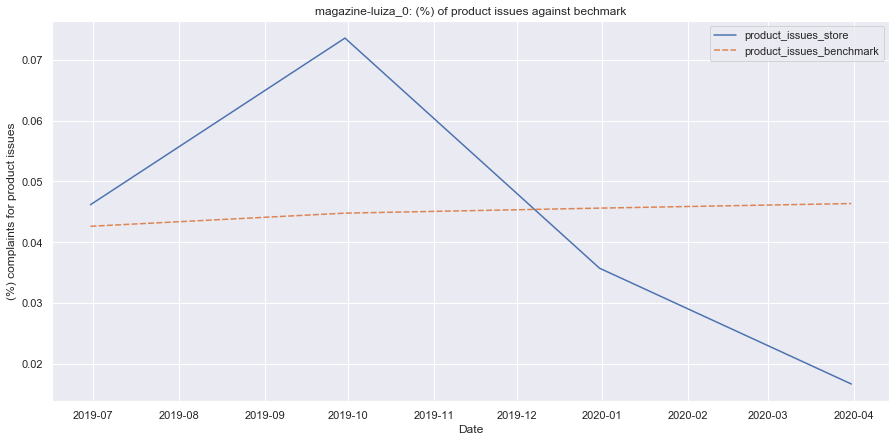

In [263]:
import seaborn as sns

# Example of metric comparison
store_id = "magazine-luiza_0"
store_class = store_class_map[store_id]
metric = "product_issues"

def get_store_bechmark_comparison(store_id: str, metric: str, stores_ts: "pd.DataFrame", benchmark_ts: "pd.DataFrame")-> pd.DataFrame:
    """
    Provides a dataframe with store_id x benchmark on a particular metric
    """
    # get benchmark class
    store_class_map = stores_ts[["store_id", "store_type"]].drop_duplicates().set_index("store_id").to_dict()["store_type"]
    store_class = store_class_map[store_id]
    
    # Filter and agg with benchmark data
    tmp_df = stores_ts.loc[(stores_ts.store_id == store_id)][["date_comment", metric]]
    tmp_df = tmp_df.merge(benchmark_ts.loc[(benchmark_ts.store_type == store_class)][["date_comment", metric]], 
                          left_on="date_comment", right_on="date_comment", suffixes=('_store', '_benchmark'))
    tmp_df.index = tmp_df.date_comment
    tmp_df =tmp_df.drop("date_comment", axis=1)
    return tmp_df

def format_metric_display(metric):
    """
    Format metric name display
    """
    return " ".join(metric.split("_"))


# Create figure
tmp_df = get_store_bechmark_comparison(store_id, metric, stores_ranked_ts, benchmarks)
fig, ax = plt.subplots(figsize=(15,7))
sns.set(style="darkgrid")
sns.lineplot(data=tmp_df, ax=ax)
plt.title(f"{store_id}: (%) of {format_metric_display(metric)} against bechmark")
ax.set(xlabel='Date', ylabel=f'(%) complaints for {format_metric_display(metric)}')
